<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/sgrepo/bouquecreator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rembg[gpu]

In [ ]:
!wget https://flower-p.com/wp/blog/wp-content/uploads/2019/06/190603-mango-150x150.jpg -O /content/torukokikyou.jpg

In [10]:
from rembg import remove
import cv2

imgname = "crop_oji"
input_path = f'/content/{imgname}.jpg'
output_path = f"/content/{imgname}_out.jpg"
mask_path = f'/content/{imgname}_mask.jpg'

input = cv2.imread(input_path)
output = remove(input)
cv2.imwrite(output_path, output)
mask = output[:, :, 3]
cv2.imwrite(mask_path, mask)

True

In [ ]:
!wget https://mille-la-chouette.jp/wp/wp-content/uploads/2020/01/bq0081_01.jpg -O /content/bouque.jpg

Create Mask

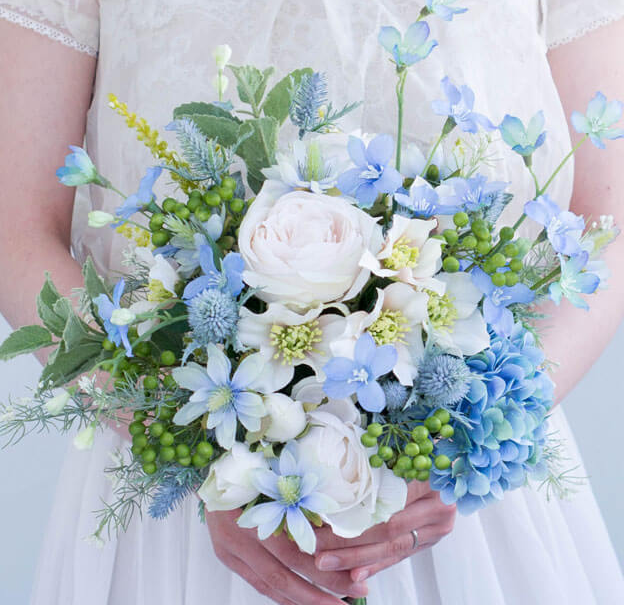

In [7]:
# for bouque
import cv2
from PIL import Image
import numpy as np
img = cv2.imread("/content/bouque.jpg")
h, w = img.shape[:2]
crop_img = img[int(h * 0.12):int(h * 0.75), int(w * 0.15):int(w * 0.8), :]
mask_img = np.zeros_like(img)
mask_img[int(h * 0.12):int(h * 0.75), int(w * 0.15):int(w * 0.8), :] = 255
cv2.imwrite("/content/bouque_part_mask.jpg", mask_img)
display(Image.fromarray(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)))

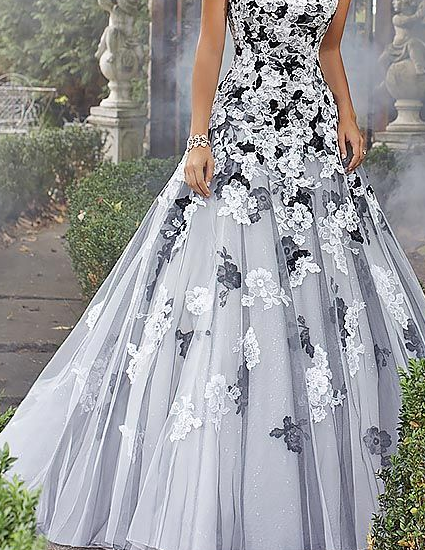

In [6]:
# for colordress
import cv2
from PIL import Image
import numpy as np
img = cv2.imread("/content/colordress.jpg")
h, w = img.shape[:2]
crop_img = img[int(h * 0.35):int(h * 0.9), int(w * 0.05):int(w * 0.9), :]
mask_img = np.zeros_like(img)
mask_img[int(h * 0.35):int(h * 0.9), int(w * 0.05):int(w * 0.9), :] = 255
cv2.imwrite("/content/colordress_mask.jpg", mask_img)
display(Image.fromarray(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)))

Only ControlNet

In [ ]:
!pip install diffusers transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install controlnet_aux

In [ ]:
from controlnet_aux import MLSDdetector, HEDdetector
from PIL import Image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# preprocessor = MLSDdetector.from_pretrained('lllyasviel/ControlNet')
preprocessor = HEDdetector.from_pretrained('lllyasviel/Annotators')

  0%|          | 0/40 [00:00<?, ?it/s]

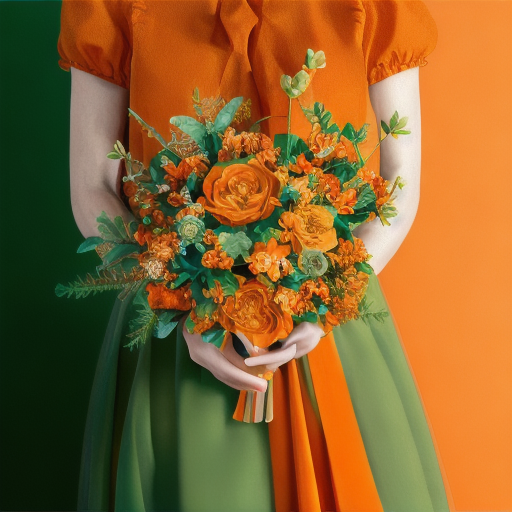

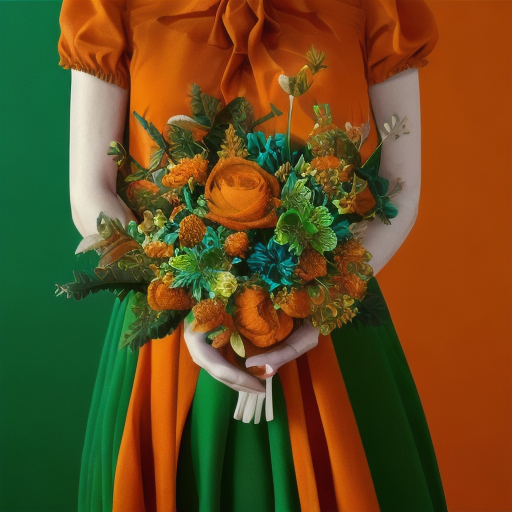

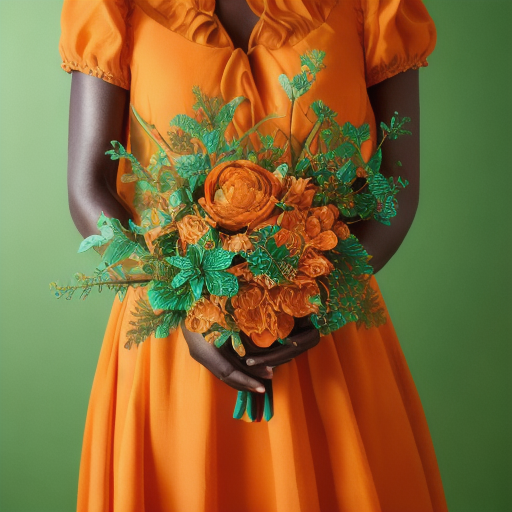

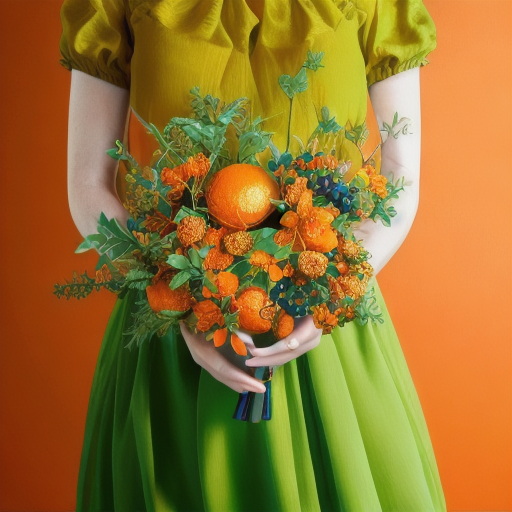

In [30]:
image = Image.open("/content/bouque.jpg")

image = preprocessor(image)
seed = 0
generator = torch.Generator(device=device)
generator = generator.manual_seed(seed)
images = pipe("(super realistic), (beautiful orange bouque), (deep green color dress), (beautiful skin arm and hands), in front of white wall, 8k", image, num_inference_steps=40, generator=generator, num_images_per_prompt=4).images


for im in images:
  display(im)

Controlnet Inpaint Pipeline

In [ ]:
from controlnet_aux import MLSDdetector, HEDdetector
from PIL import Image
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "SG161222/Realistic_Vision_V2.0", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# preprocessor = MLSDdetector.from_pretrained('lllyasviel/ControlNet')
preprocessor = HEDdetector.from_pretrained('lllyasviel/Annotators')

  0%|          | 0/40 [00:00<?, ?it/s]

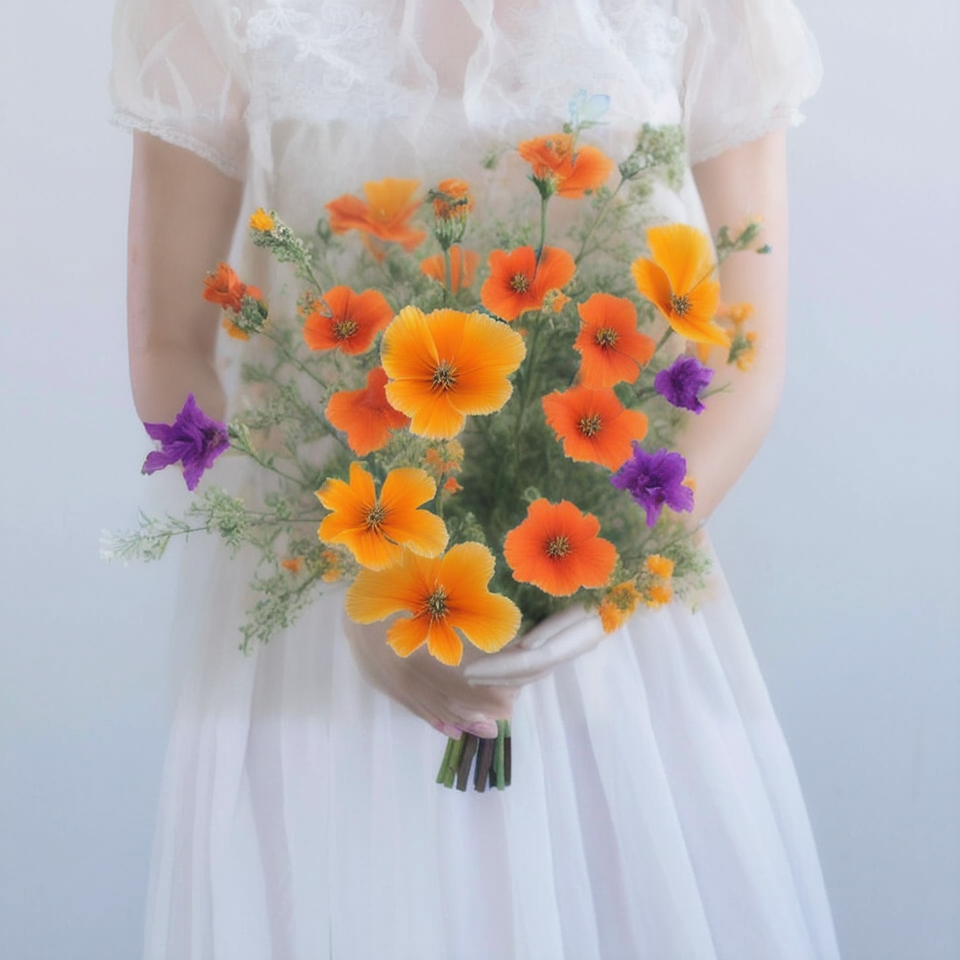

In [3]:
# generate image
image = Image.open("/content/bouque.jpg")
hed_image = preprocessor(image)
mask_image = Image.open("/content/bouque_part_mask.jpg")
text_prompt = "(beautiful bouque: 1.0), orange cosmos, orange rose, yellow bellflower, (super realistic), 8k"

generator = torch.manual_seed(1)
new_image = pipe(
    text_prompt,
    num_inference_steps=40,
    generator=generator,
    image=image,
    control_image=hed_image,
    mask_image=mask_image
).images[0]

display(new_image)

Delete bouque

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
inpaint_pipe = inpaint_pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

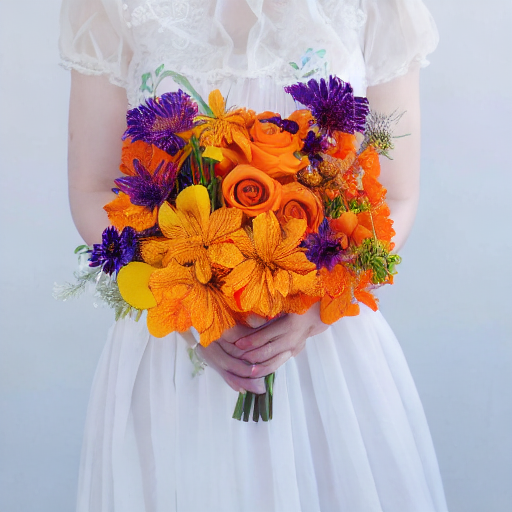

In [7]:
from PIL import Image
prompt = "(beautiful bouque: 1.0), orange cosmos, orange rose, yellow bellflower, (super realistic), 8k"
init_image = Image.open("/content/bouque.jpg")
mask_image = Image.open("/content/bouque_part_mask.jpg")
image = inpaint_pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
display(image)

ColorDress

In [ ]:
!wget https://i.pinimg.com/736x/79/ba/f0/79baf0f4507dc8ec49df58a339894d28--colorful-wedding-dresses-colorful-weddings.jpg -O /content/colordress.jpg

In [ ]:
from controlnet_aux import MLSDdetector, HEDdetector, CannyDetector
from PIL import Image
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "SG161222/Realistic_Vision_V2.0", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
preprocessor = HEDdetector.from_pretrained('lllyasviel/Annotators')

  0%|          | 0/40 [00:00<?, ?it/s]

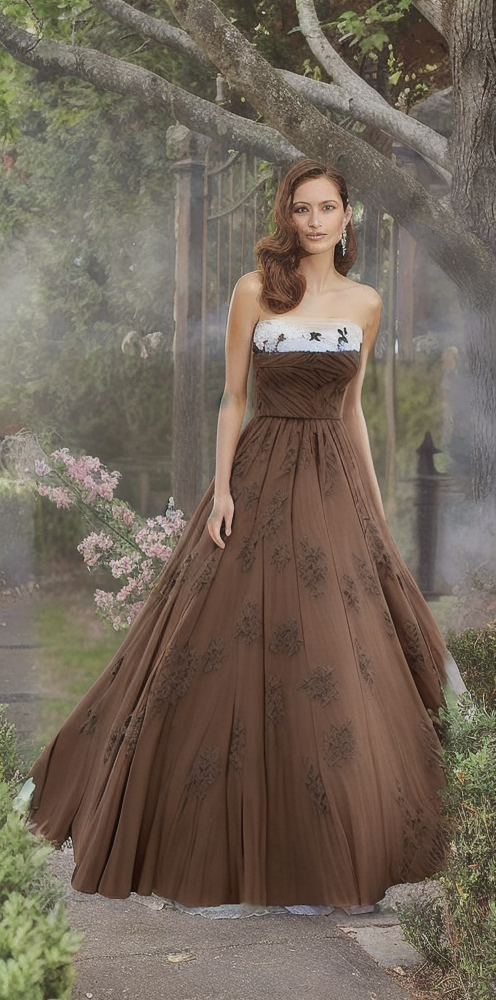

In [8]:
import cv2
import numpy as np

img_path = "/content/colordress.jpg"
image = Image.open(img_path)
# pre_image = preprocessor(image)

low_threshold = 100
high_threshold = 200

pre_image = cv2.Canny(cv2.imread(img_path), low_threshold, high_threshold)
pre_image = pre_image[:, :, None]
pre_image = np.concatenate([pre_image, pre_image, pre_image], axis=2)
pre_image = Image.fromarray(pre_image)

mask_image = Image.open("/content/colordress_mask.jpg")
text_prompt = "(beautiful brown dress: 1.0),(super realistic), 8k"

generator = torch.manual_seed(1)
new_image = pipe(
    text_prompt,
    num_inference_steps=40,
    generator=generator,
    image=image,
    control_image=pre_image,
    mask_image=mask_image
).images[0]

display(new_image)

In [ ]:
# どんな感じのドレスがいいかまでは検索promptを利用して生成すればいい感じ
# その後のテイストの変換はcontrolnet inpaintを利用するとできる感じ
# FaceSwapで顔を変更

Face Swap
http://cedro3.com/ai/sberswap/

In [ ]:
# http://cedro3.com/ai/sberswap/

%cd /content
!git clone https://github.com/cedro3/sber-swap.git
%cd sber-swap

# load arcface
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/iresnet.py

# load landmarks detector
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/glintr100.onnx
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/scrfd_10g_bnkps.onnx

# load model itself
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/sber-swap-v2.0/G_unet_2blocks.pth

# load super res model
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/super-res/10_net_G.pth

# Install required libraries
!pip install mxnet-cu112
!pip install onnxruntime-gpu==1.12
!pip install insightface==0.2.1
!pip install kornia==0.5.4

!rm /usr/local/lib/python3.10/dist-packages/insightface/model_zoo/model_zoo.py #change the path to python in case you use a different version
!wget -P /usr/local/lib/python3.10/dist-packages/insightface/model_zoo/ https://github.com/AlexanderGroshev/insightface/releases/download/model_zoo/model_zoo.py #change the path to python in case you use a different version


In [ ]:
!pip install dill

In [ ]:
# library import
import cv2
import torch
import time
import os
from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference
from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions


# --- Initialize models ---
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

In [ ]:
source = 'satomi.jpg' #@param {type:"string"}
target = 'colordress_actress.png' #@param {type:"string"}
source_path = 'examples/images/'+source
target_path = 'examples/images/' + target


source_full = cv2.imread(source_path)
crop_size = 224 # don't change this
batch_size =  40

source = crop_face(source_full, app, crop_size)[0]
source = [source[:, :, ::-1]]

target_full = cv2.imread(target_path)
full_frames = [target_full]
target = get_target(full_frames, app, crop_size)

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
cv2.imwrite('examples/results/result.png', result)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


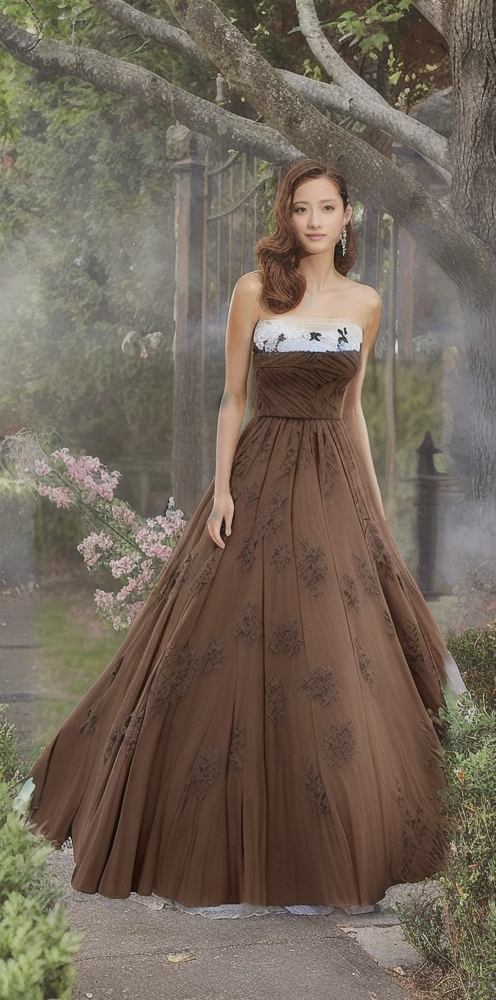

In [12]:
from PIL import Image
display(Image.open("/content/sber-swap/examples/results/result.png"))

In [ ]:
#@title video
source = 'satomi.jpg' #@param {type:"string"}
video = 'yui.mp4' #@param {type:"string"}
source_path = 'examples/images/'+source
path_to_video = 'examples/videos/'+video

source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this
batch_size =  40

source = crop_face(source_full, app, crop_size)[0]
source = [source[:, :, ::-1]]

full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

get_final_video(final_frames_list,
                crop_frames_list,
                full_frames,
                tfm_array_list,
                OUT_VIDEO_NAME,
                fps,
                handler)

add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

print(f'Full pipeline took {time.time() - START_TIME}')
print(f"Video saved with path {OUT_VIDEO_NAME}")

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_file = open(OUT_VIDEO_NAME, "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")

ヘアスタイルの変更

In [8]:
!pip install -q flatbuffers==2.0.0
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 44.7 MB/s eta 0:00:00


In [ ]:
%cd /content
!git clone https://github.com/ibaiGorordo/Mediapipe-Halloween-Examples.git

In [ ]:
!pip install imread-from-url

In [13]:
# change utils/fire_hair_utils.py
# self.session = onnxruntime.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
%cd /content/Mediapipe-Halloween-Examples/
import cv2
import numpy as np
from PIL import Image

from utils.fire_hair_utils import HairSegmentation, get_fire_gif

/content/Mediapipe-Halloween-Examples


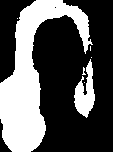

In [14]:
frame = cv2.imread("/content/crop_colordress.jpg")

img_height, img_width, _ = frame.shape

# Inialize hair segmentation model
hair_segmentation = HairSegmentation(img_width, img_height)

# Segment hair
hair_mask = hair_segmentation(frame)

# Draw fire
combined_image = hair_segmentation.draw_fire_hair(frame, hair_mask)

# display(Image.fromarray(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)))
cv2.imwrite("/content/crop_colordress_mask.jpg", hair_mask * 255)
display(Image.fromarray(hair_mask * 255))

In [ ]:
# 顔が小さい状態で描けるとあんまりいい推定ができないので
# insightfaceで顔をしっかりと推定して、cropしたのちに髪型を抽出して、元の画像に戻すが良さそう
# 普通にcontrolnet inpaintを利用しただけじゃ髪型は変化させられなそう。stable diffusionでは無理そう

In [ ]:
!pip install insightface==0.7.3

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv1d_pad_to_nc1d': '0', 'enable_cuda_graph': '0', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_alloc': '0', 'device_id': '0'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv1d_pad_to_nc1d': '0', 'enable_cuda_graph': '0', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '184467

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


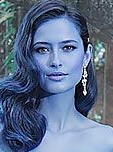

In [3]:
import cv2
import numpy as np
from PIL import Image
import insightface
from insightface.app import FaceAnalysis

app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))
source_img = cv2.imread("/content/colordress.jpg")
faces = app.get(source_img)
rimg = app.draw_on(source_img, faces)


xmin, ymin, xmax, ymax = faces[0].bbox
crop_img = source_img[int(ymin - 20):int(ymax + 60), int(xmin - 30):int(xmax + 30), :]
crop_mask_img = np.zeros_like(source_img)
crop_mask_img[int(ymin - 20):int(ymax + 60), int(xmin - 30):int(xmax + 30), :] = 255
cv2.imwrite("/content/crop_colordress.jpg", crop_img)
cv2.imwrite("/content/colordress_face_mask.jpg", crop_mask_img)
display(Image.fromarray(crop_img))


In [ ]:
# hair change with controlnet inpaint pipeline?

In [1]:
from controlnet_aux import MLSDdetector, HEDdetector
from PIL import Image
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "SG161222/Realistic_Vision_V2.0", controlnet=controlnet, torch_dtype=torch.float16, safety_checker=None,
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

device = "cuda" if torch.cuda.is_available() else "cpu"

unet/diffusion_pytorch_model.safetensors not found
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
preprocessor = HEDdetector.from_pretrained('lllyasviel/Annotators')

  0%|          | 0/40 [00:00<?, ?it/s]

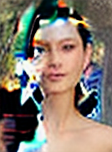

In [3]:
import cv2
from PIL import Image
import numpy as np
# generate image
img_path = "/content/crop_colordress.jpg"
image = Image.open(img_path)

low_threshold = 100
high_threshold = 200

pre_image = cv2.Canny(cv2.imread(img_path), low_threshold, high_threshold)
pre_image = pre_image[:, :, None]
pre_image = np.concatenate([pre_image, pre_image, pre_image], axis=2)
pre_image = Image.fromarray(pre_image)
mask_image = Image.open("/content/crop_colordress_mask.jpg")
text_prompt = "(beautiful woman: 1.0), (european: 1.0), (beautiful white skin), black hair, (super realistic), 8k"

generator = torch.manual_seed(1)
new_image = pipe(
    text_prompt,
    num_inference_steps=40,
    generator=generator,
    image=image,
    control_image=pre_image,
    mask_image=mask_image
).images[0]

display(new_image)

Style Hair

[HairClip](https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/HairCLIP_demo.ipynb#scrollTo=R-Y5auuvnnnT) -> Crash


In [ ]:
%cd /content
!git clone https://github.com/Taeu/Style-Your-Hair.git

In [ ]:
!mkdir /content/hairstyles
!gdown https://drive.google.com/drive/folders/1RxzbNcKb3bPDKccyo300YXCJ8EvZSaIL -O /content/hairstyles --folder

In [4]:
!pip install -q face_alignment face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
# preprocess: arrange (1024, 1024)
import cv2
source_img = cv2.imread("/content/sber-swap/examples/images/angelina.jpg")
target_img = cv2.imread("/content/sber-swap/examples/images/nanako.jpg")

cv2.imwrite("/content/source.jpg", cv2.resize(source_img, (1024, 1024)))
cv2.imwrite("/content/target.jpg", cv2.resize(target_img, (1024, 1024)))

True

In [ ]:
%cd /content/Style-Your-Hair
!python main.py --input_dir /content/hairstyles --im_path1 /content/source.jpg --im_path2 /content/target.jpg \
    --output_dir ./style_your_hair_output/ \
    --warp_loss_with_prev_list delta_w style_hair_slic_large \
    --save_all --version final --flip_check